# 1. Simple Dataset downloading pipeline

In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import datasets
import torchvision
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, huggingface_dataset):
        self.dataset = huggingface_dataset
        self.transform =     transformation_list =  torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)), # IMPORTANT SIZE OF IMAGE (224, 224) or (256,256)
            torchvision.transforms.Grayscale(),        # TODO: Change to colored image
            torchvision.transforms.ToTensor(),
        ])

    def __len__(self):
        self.dataset_length = len(self.dataset)
        return self.dataset_length

    def __getitem__(self,index):
        img   = self.dataset[index]['image']
        label = self.dataset[index]['labels']
        
        img_transformed = self.transform(img).to(dtype=torch.float32)

        return img_transformed,label
    
training_dataset                     = Custom_Dataset(huggingface_dataset = datasets.load_dataset("microsoft/cats_vs_dogs", split="train"))
training_dataset, validation_dataset = torch.utils.data.random_split(training_dataset, [0.9, 0.1])
training_dataloader   = torch.utils.data.DataLoader( dataset= training_dataset     , batch_size= 5, shuffle= True )
validation_dataloader = torch.utils.data.DataLoader( dataset= validation_dataset   , batch_size= 5, shuffle= True )

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1491: FutureWarning: The repository for microsoft/cats_vs_dogs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/microsoft/cats_vs_dogs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Input shape: torch.Size([5, 1, 224, 224])
Labels: tensor([0, 0, 1, 0, 1])


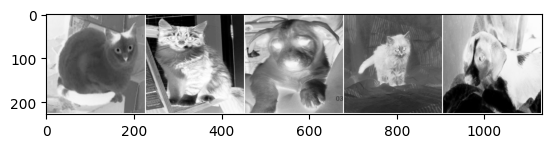

In [3]:
x, y = next(iter(training_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys"); # TODO: Change to colored image


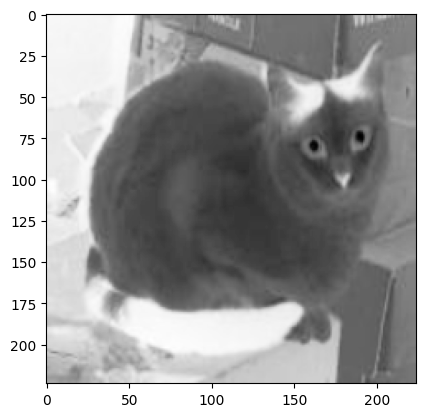

In [4]:
plt.imshow(torchvision.transforms.ToPILImage()(x[0]), cmap="Greys")

## 1.5 Adding Noise to existing Data

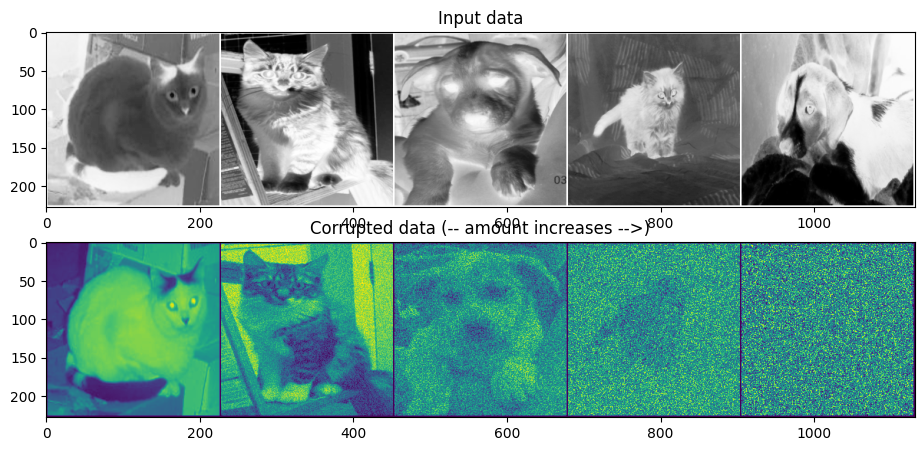

In [5]:
def add_noise(input_image, amount): # AMOUNT IS A FLAG, to tell how important the noise is
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise       = torch.rand_like(input_image)
    amount      = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
    noisy_image = input_image * (1-amount) + (noise * amount)
    return noisy_image

def plot_progressive_noise_addition(x): # Plotting the input data
    # Plotting the input data
    fig, axs = plt.subplots(2, 1, figsize=(12, 5))
    axs[0].set_title('Input data')
    axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

    # Adding noise
    # AMOUNT between 0 to 1
    amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
    noised_x = add_noise(x, amount)

    # Plotting the noised version
    axs[1].set_title('Corrupted data (-- amount increases -->)')
    axs[1].imshow(torchvision.utils.make_grid(noised_x)[0]);
    
plot_progressive_noise_addition(x)

# 2. Simple Model

In [6]:
class BasicUNet(torch.nn.Module):
    """A minimal UNet implementation."""
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            torch.nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            torch.nn.Conv2d(32, 64, kernel_size=5, padding=2),
            torch.nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(64, 64, kernel_size=5, padding=2),
            torch.nn.Conv2d(64, 32, kernel_size=5, padding=2),
            torch.nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU() # The activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for layer_number, layer in enumerate(self.down_layers):
            x = self.act(layer(x)) # Through the layer and the activation function
            if layer_number < 2: # For all but the third (final) down layer:
              h.append(x) # Storing output for skip connection
              x = self.downscale(x) # Downscale ready for the next layer
              
        for layer_number, layer in enumerate(self.up_layers):
            if layer_number > 0: # For all except the first up layer
              x = self.upscale(x) # Upscale
              x += h.pop() # Fetching stored output (skip connection)
            x = self.act(layer(x)) # Through the layer and the activation function
            
        return x
    
net = BasicUNet(in_channels = 1, out_channels = 1)
x   = torch.rand(5, 1, 224, 224)
net(x).shape

torch.Size([5, 1, 224, 224])

# 3. Simple Model Training Pipeline

In [7]:
def TRAIN_MODEL(model, training_dataloader, validation_dataloader= None):
    model.train(mode=True)
    LOSS_FUNC  = nn.MSELoss()
    OPTIMIZER  = torch.optim.Adam(net.parameters(), lr=1e-3)
    for epoch in range(n_epochs):
        for input_image, y_actual in (pbar := tqdm(training_dataloader)):
            # Get some data and prepare the corrupted version
            # INPUT_IMAGE -> NOISY_INPUT_IMAGE
            input_image        = input_image.to(device) # Data on the GPU
            noise_amount       = torch.rand(input_image.shape[0]).to(device) # Pick random noise amounts
            input_image_noisy  = add_noise(input_image, noise_amount) # Create our noisy x

            # Get the model prediction
            predicted_denoised_image = model(input_image_noisy)

            # Calculate the loss
            loss = LOSS_FUNC(predicted_denoised_image, input_image) # How close is the output to the true 'clean' x?

            # Backprop and update the params:
            OPTIMIZER.zero_grad()
            loss.backward()
            OPTIMIZER.step()

            # Store the loss for later
            losses.append(loss.item())
            pbar.set_description(f'loss={loss.item():4f}')

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(losses[-len(training_dataloader):])/len(training_dataloader)
        print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')
    
    # View the loss curve
    plt.plot(losses)
    plt.ylim(0, 0.1);
    

loss=0.007245: 100%|██████████| 4214/4214 [03:19<00:00, 21.16it/s]


Finished epoch 0. Average loss for this epoch: 0.013679


loss=0.009157: 100%|██████████| 4214/4214 [03:17<00:00, 21.36it/s]


Finished epoch 1. Average loss for this epoch: 0.013347


loss=0.012532: 100%|██████████| 4214/4214 [03:18<00:00, 21.22it/s]


Finished epoch 2. Average loss for this epoch: 0.017802


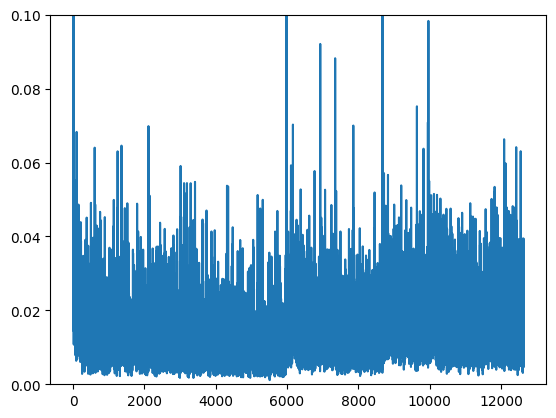

In [8]:

# Create the network
net = BasicUNet(in_channels = 1, out_channels = 1).to(device)
 
losses  = []
n_epochs = 3
TRAIN_MODEL(net, training_dataloader)